[View in Colaboratory](https://colab.research.google.com/github/NicolasMauge/Pytorch_Projects/blob/master/Training_92p_K80.ipynb)

In [1]:
!git clone https://github.com/NicolasMauge/Utils
!git clone https://github.com/NicolasMauge/learning_projects
!. Utils/colab_init.sh
import sys
sys.path.append('Utils')
import colab_utils as utils

sys.path.append('learning_projects')
import schedulers as sch

fatal: destination path 'Utils' already exists and is not an empty directory.
fatal: destination path 'Pytorch_Projects' already exists and is not an empty directory.
Install of the PyTorch packages
Install of the PyDrive package
Install of the kaggle package


In [0]:
#!cd Pytorch_Projects && git fetch --all && git reset --hard origin/master
#import schedulers as sch

# Import of the libraries

In [0]:
# Import Libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torchvision.models.resnet import resnet18

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

import matplotlib.pyplot as plt

from torch.nn import functional as F

from PIL import Image

# Definition of the model

## Model

In [0]:
import models.preact_resnet2 as resnet18_pre
import models.wideresnet as wide
from train import BasicModel

In [0]:
def init_resnet18():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = resnet18_pre.ResNet18().to(device).half()

    if device == 'cuda':
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True
    
    return model

In [6]:
# test to verify that the model can work with cifar10
y = init_resnet18()(torch.randn(100,3,32,32))
print(y.size())

# expected "torch.Size([100, 10])"

torch.Size([100, 10])


# Definition of the parameters and load of the data

In [0]:
# from https://github.com/bkj/basenet/blob/master/examples/cifar/cifar10.py
def ReflectionPadding(margin=(4, 4)):
    
    def _reflection_padding(x):
        x = np.asarray(x)
        if len(x.shape) == 2:
            x = np.pad(x, [(margin[0], margin[0]), (margin[1], margin[1])], mode='reflect')
        elif len(x.shape) == 3:
            x = np.pad(x, [(margin[0], margin[0]), (margin[1], margin[1]), (0, 0)], mode='reflect')
        
        return Image.fromarray(x)
    
    return transforms.Lambda(_reflection_padding)

In [8]:
batch_size = 128   

transform_train = transforms.Compose([
    ReflectionPadding(margin=(4, 4)),
    transforms.RandomCrop(32),
    transforms.ColorJitter(.25,.25,.25),
    transforms.RandomRotation(2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159]),
])
# --> the minimal transform_train is 
# transform_train = transforms.Compose([
#     transforms.ToTensor()
# ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


# Schedulers

## Some definitions

In [0]:
def plot_lr(clr, nb_iter):
    test = [clr(n_iter) for n_iter in range(0, nb_iter)]

    plt.plot(range(0,nb_iter), test, color = "red")
    plt.xlabel("Step")
    plt.ylabel("Learning rate")
    plt.title("Lr triangle")
    plt.grid(True,which="both")
    plt.show()

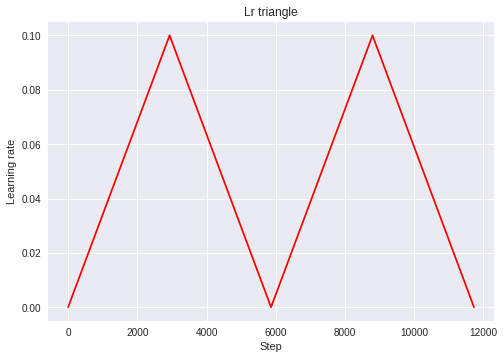

In [10]:
clr = sch.CyclicLR(base_lr=0.0001, max_lr=0.1, iter_by_epoch=391, cycle_len=15)
plot_lr(clr, 391*30)

# Training

In [0]:
base_lr=0.01
#wd = 4e-4
wd = 1e-4

error = nn.CrossEntropyLoss()
model_class = BasicModel(init_resnet18(), train_loader, test_loader, error, weight_decay=wd)

Epochs: 0 Cycle: 0 Iter: 391  Tr Loss: 0.01281625  Tr Acc: 39 Test Acc: 56.63 Last lr: 0.1
CPU times: user 1min, sys: 20.3 s, total: 1min 20s
Wall time: 1min 26s
Epochs: 1 Cycle: 0 Iter: 22  Tr Loss: 0.013642397793856535  Tr Acc: 44 Test Acc: 14.66 Last lr: 0.2686368286445009


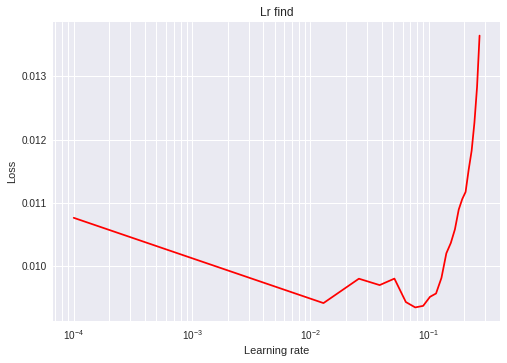

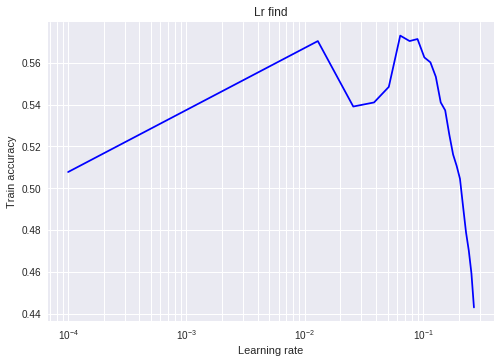

In [12]:
#warm up + lr find
%time model_class.train(1, cycle_len=1, lr=0.1)
model_class.lr_find([0.0001, 5], cycle_len=1)
model_class = BasicModel(init_resnet18(), train_loader, test_loader, error, weight_decay=wd)

In [13]:
clr = sch.CyclicLR(base_lr=0.0001, max_lr=0.2, iter_by_epoch=len(train_loader), cycle_len=30)
%time model_class.train(1, cycle_len=30, sched_lr=clr)

Epochs: 0 Cycle: 0 Iter: 391  Tr Loss: 0.0152020703125  Tr Acc: 27 Test Acc: 40.5 Last lr: 0.013392583120204611
Epochs: 1 Cycle: 0 Iter: 782  Tr Loss: 0.01065625  Tr Acc: 49 Test Acc: 58.11 Last lr: 0.026719249786871277
Epochs: 2 Cycle: 0 Iter: 1173  Tr Loss: 0.00806935546875  Tr Acc: 62 Test Acc: 69.64 Last lr: 0.040045916453537944
Epochs: 3 Cycle: 0 Iter: 1564  Tr Loss: 0.006423984375  Tr Acc: 71 Test Acc: 74.86 Last lr: 0.05337258312020461
Epochs: 4 Cycle: 0 Iter: 1955  Tr Loss: 0.00555798828125  Tr Acc: 75 Test Acc: 75.49 Last lr: 0.06669924978687128
Epochs: 5 Cycle: 0 Iter: 2346  Tr Loss: 0.004965458984375  Tr Acc: 78 Test Acc: 78.3 Last lr: 0.08002591645353795
Epochs: 6 Cycle: 0 Iter: 2737  Tr Loss: 0.0045412451171875  Tr Acc: 80 Test Acc: 79.96 Last lr: 0.0933525831202046
Epochs: 7 Cycle: 0 Iter: 3128  Tr Loss: 0.004187294921875  Tr Acc: 81 Test Acc: 80.61 Last lr: 0.10667924978687132
Epochs: 8 Cycle: 0 Iter: 3519  Tr Loss: 0.0038972998046875  Tr Acc: 82 Test Acc: 79.17 Last lr:

In [14]:
model_class.save_model("cifar10_93p.pth", to_google_drive=True)

title: cifar10_93p.pth, mimeType: application/octet-stream


In [24]:
model_class = BasicModel(init_resnet18(), train_loader, test_loader, error, weight_decay=wd)
clr = sch.CyclicLR(base_lr=0.0001, max_lr=0.2, iter_by_epoch=len(train_loader), cycle_len=20)
%time model_class.train(1, cycle_len=20, sched_lr=clr)

Epochs: 0 Cycle: 0 Iter: 391  Tr Loss: 0.0145059765625  Tr Acc: 30 Test Acc: 49.04 Last lr: 0.020038874680306917
Epochs: 1 Cycle: 0 Iter: 782  Tr Loss: 0.0101457421875  Tr Acc: 52 Test Acc: 48.54 Last lr: 0.04002887468030689
Epochs: 2 Cycle: 0 Iter: 1173  Tr Loss: 0.0079777734375  Tr Acc: 63 Test Acc: 71.76 Last lr: 0.060018874680306915
Epochs: 3 Cycle: 0 Iter: 1564  Tr Loss: 0.006620126953125  Tr Acc: 70 Test Acc: 74.49 Last lr: 0.08000887468030689
Epochs: 4 Cycle: 0 Iter: 1955  Tr Loss: 0.005774072265625  Tr Acc: 74 Test Acc: 75.02 Last lr: 0.09999887468030691
Epochs: 5 Cycle: 0 Iter: 2346  Tr Loss: 0.0050854443359375  Tr Acc: 78 Test Acc: 73.94 Last lr: 0.11998887468030693
Epochs: 6 Cycle: 0 Iter: 2737  Tr Loss: 0.0045686376953125  Tr Acc: 80 Test Acc: 77.18 Last lr: 0.13997887468030693
Epochs: 7 Cycle: 0 Iter: 3128  Tr Loss: 0.004195341796875  Tr Acc: 81 Test Acc: 79.77 Last lr: 0.1599688746803069
Epochs: 8 Cycle: 0 Iter: 3519  Tr Loss: 0.003791533203125  Tr Acc: 83 Test Acc: 82.13